
## Import required libraries

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Load and preprocess data


In [20]:
# Load the preprocessed data
stock_data = pd.read_csv('processed_amzn_data.csv', index_col='Date')

# Split features and target
features = stock_data.values[:, :-1]
target = stock_data.iloc[:, -1].values

# Split into train and test sets
train_split = int(stock_data.shape[0] * 0.8)
train_features, test_features = features[:train_split, :], features[train_split:, :]
train_target, test_target = target[:train_split], target[train_split:]

print(f'Train features shape: {train_features.shape}, Train target shape: {train_target.shape}')
print(f'Test features shape: {test_features.shape}, Test target shape: {test_target.shape}')

# Scale the data
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

train_features_scaled = feature_scaler.fit_transform(train_features)
test_features_scaled = feature_scaler.transform(test_features)

train_target_scaled = target_scaler.fit_transform(train_target.reshape(-1, 1))
test_target_scaled = target_scaler.transform(test_target.reshape(-1, 1))

Train features shape: (190, 26), Train target shape: (190,)
Test features shape: (48, 26), Test target shape: (48,)


## Define the Variational Autoencoder (VAE) model

In [21]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        # Encoder
        encoder_layers = []
        for i in range(1, len(config)):
            encoder_layers.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        # Decoder
        decoder_layers = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])
        for i in range(len(config) - 1, 1, -1):
            decoder_layers.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        decoder_layers.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        result = self.decoder(z)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        output = self.decode(z)
        return output, z, mu, log_var

## Train the Variational Autoencoder Model (VAE)

In [22]:
# Set up VAE training
vae_config = [26, 400, 400, 400, 10]
latent_dim = 10
batch_size = 128
learning_rate = 0.0003
num_epochs = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = VAE(vae_config, latent_dim).to(device)
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_features_scaled).float()),
                          batch_size=batch_size, shuffle=False)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

# Train the VAE
vae_loss_history = np.zeros(num_epochs)
for epoch in range(num_epochs):
    epoch_loss = []
    for (x,) in train_loader:
        x = x.to(device)
        # optimizer.zero_grad()
        reconstructed, z, mu, log_var = vae_model(x)
        reconstruction_loss = F.binary_cross_entropy(reconstructed, x)
        kl_divergence = 0.5 * torch.sum(-1 - log_var + mu.pow(2) + log_var.exp())
        loss = reconstruction_loss + kl_divergence
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    vae_loss_history[epoch] = sum(epoch_loss)
    print(f'[{epoch+1}/{num_epochs}] VAE Loss: {sum(epoch_loss):.4f}')

[1/500] VAE Loss: 51.5756
[2/500] VAE Loss: 48.0656
[3/500] VAE Loss: 47.7498
[4/500] VAE Loss: 48.9557
[5/500] VAE Loss: 49.0208
[6/500] VAE Loss: 47.4000
[7/500] VAE Loss: 45.8754
[8/500] VAE Loss: 45.1700
[9/500] VAE Loss: 44.9470
[10/500] VAE Loss: 45.0371
[11/500] VAE Loss: 45.1702
[12/500] VAE Loss: 45.1264
[13/500] VAE Loss: 44.7890
[14/500] VAE Loss: 44.1663
[15/500] VAE Loss: 43.3685
[16/500] VAE Loss: 42.4691
[17/500] VAE Loss: 41.5570
[18/500] VAE Loss: 40.7331
[19/500] VAE Loss: 40.1228
[20/500] VAE Loss: 39.8855
[21/500] VAE Loss: 40.1668
[22/500] VAE Loss: 40.9422
[23/500] VAE Loss: 41.8344
[24/500] VAE Loss: 42.1658
[25/500] VAE Loss: 41.4912
[26/500] VAE Loss: 39.9867
[27/500] VAE Loss: 38.2568
[28/500] VAE Loss: 36.8430
[29/500] VAE Loss: 35.9661
[30/500] VAE Loss: 35.6084
[31/500] VAE Loss: 35.6152
[32/500] VAE Loss: 35.8266
[33/500] VAE Loss: 36.0932
[34/500] VAE Loss: 36.3054
[35/500] VAE Loss: 36.4279
[36/500] VAE Loss: 36.4475
[37/500] VAE Loss: 36.3616
[38/500] V

## Plot VAE training loss

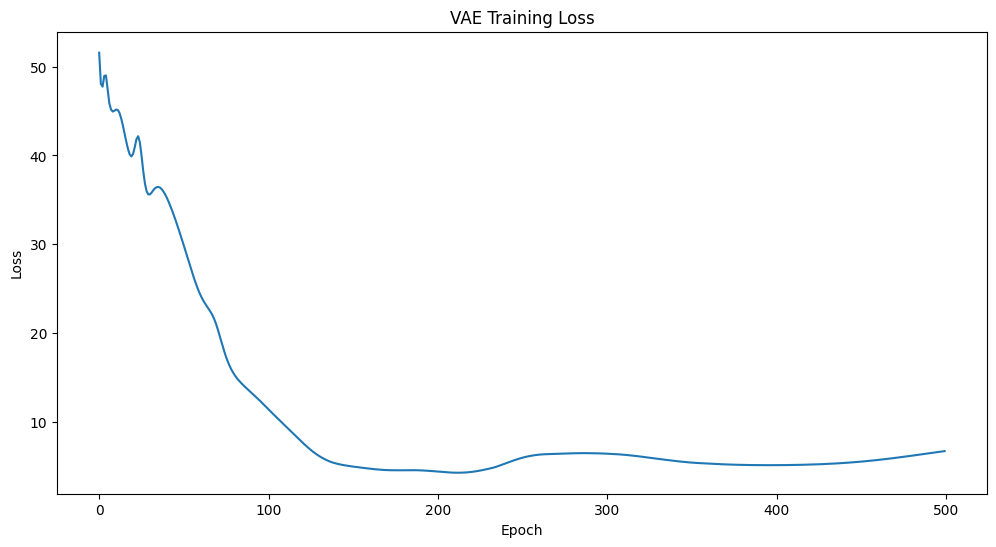

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(vae_loss_history)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Generate latent representations and prepare data for GRU

In [24]:
# Generate latent representations
vae_model.eval()
with torch.no_grad():
    _, train_latent, _, _ = vae_model(torch.from_numpy(train_features_scaled).float().to(device))
    _, test_latent, _, _ = vae_model(torch.from_numpy(test_features_scaled).float().to(device))

# Concatenate original features with latent representations
train_features_augmented = np.concatenate((train_features_scaled, train_latent.cpu().numpy()), axis=1)
test_features_augmented = np.concatenate((test_features_scaled, test_latent.cpu().numpy()), axis=1)

def create_sequences(features, targets, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(features)):
        x.append(features[i-sequence_length:i])
        y.append(targets[i])
    return np.array(x), np.array(y)

sequence_length = 5
train_sequences, train_targets = create_sequences(train_features_augmented, train_target_scaled, sequence_length)
test_sequences, test_targets = create_sequences(test_features_augmented, test_target_scaled, sequence_length)

print(f'Train sequences shape: {train_sequences.shape}, Train targets shape: {train_targets.shape}')
print(f'Test sequences shape: {test_sequences.shape}, Test targets shape: {test_targets.shape}')

Train sequences shape: (185, 5, 36), Train targets shape: (185, 1)
Test sequences shape: (43, 5, 36), Test targets shape: (43, 1)


## Define and train the GRU model

[1/500] GRU Loss: 0.26790661
[2/500] GRU Loss: 0.25333255
[3/500] GRU Loss: 0.23980312
[4/500] GRU Loss: 0.22519285
[5/500] GRU Loss: 0.21146691
[6/500] GRU Loss: 0.19872008
[7/500] GRU Loss: 0.18570947
[8/500] GRU Loss: 0.17475063
[9/500] GRU Loss: 0.16137026
[10/500] GRU Loss: 0.14820015
[11/500] GRU Loss: 0.13631059
[12/500] GRU Loss: 0.12357757
[13/500] GRU Loss: 0.11066757
[14/500] GRU Loss: 0.09824678
[15/500] GRU Loss: 0.08613791
[16/500] GRU Loss: 0.07605910
[17/500] GRU Loss: 0.06543607
[18/500] GRU Loss: 0.05821788
[19/500] GRU Loss: 0.04713561
[20/500] GRU Loss: 0.04060165
[21/500] GRU Loss: 0.03515714
[22/500] GRU Loss: 0.03166403
[23/500] GRU Loss: 0.02879241
[24/500] GRU Loss: 0.02712619
[25/500] GRU Loss: 0.02593904
[26/500] GRU Loss: 0.02505768
[27/500] GRU Loss: 0.02425335
[28/500] GRU Loss: 0.02417758
[29/500] GRU Loss: 0.02179497
[30/500] GRU Loss: 0.02167696
[31/500] GRU Loss: 0.01934652
[32/500] GRU Loss: 0.01841358
[33/500] GRU Loss: 0.01706837
[34/500] GRU Loss: 

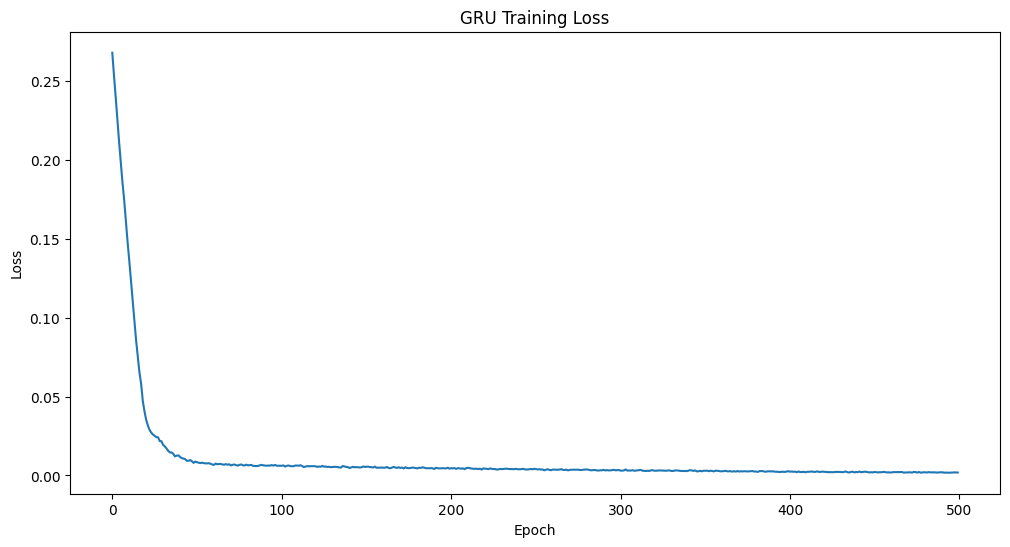

In [25]:
class GRUPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
        self.gru_2 = nn.GRU(1024, 512, batch_first=True)
        self.gru_3 = nn.GRU(512, 256, batch_first=True)
        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0_1 = torch.zeros(1, x.size(0), 1024).to(x.device)
        out_1, _ = self.gru_1(x, h0_1)
        out_1 = self.dropout(out_1)

        h0_2 = torch.zeros(1, x.size(0), 512).to(x.device)
        out_2, _ = self.gru_2(out_1, h0_2)
        out_2 = self.dropout(out_2)

        h0_3 = torch.zeros(1, x.size(0), 256).to(x.device)
        out_3, _ = self.gru_3(out_2, h0_3)
        out_3 = self.dropout(out_3)

        out_4 = self.fc_1(out_3[:, -1, :])
        out_5 = self.fc_2(out_4)
        out = self.fc_3(out_5)
        return out

# Set up GRU training
input_size = train_sequences.shape[2]
batch_size = 128
learning_rate = 0.00003
num_epochs = 500

gru_model = GRUPredictor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_sequences).float(),
                                        torch.from_numpy(train_targets).float()),
                          batch_size=batch_size, shuffle=False)

# Train the GRU model
gru_loss_history = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = gru_model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    gru_loss_history.append(epoch_loss / len(train_loader))
    print(f'[{epoch+1}/{num_epochs}] GRU Loss: {gru_loss_history[-1]:.8f}')

# Plot GRU training loss
plt.figure(figsize=(12, 6))
plt.plot(gru_loss_history)
plt.title('GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


## Evaluate the model

Train Set Evaluation:
Mean Squared Error: 9.8437
Root Mean Squared Error: 3.1375
Mean Absolute Error: 2.4221
Mean Absolute Percentage Error: 1.6866%
R-squared Score: 0.9835

Test Set Evaluation:
Mean Squared Error: 40.5489
Root Mean Squared Error: 6.3678
Mean Absolute Error: 5.2082
Mean Absolute Percentage Error: 4.0874%
R-squared Score: 0.4964


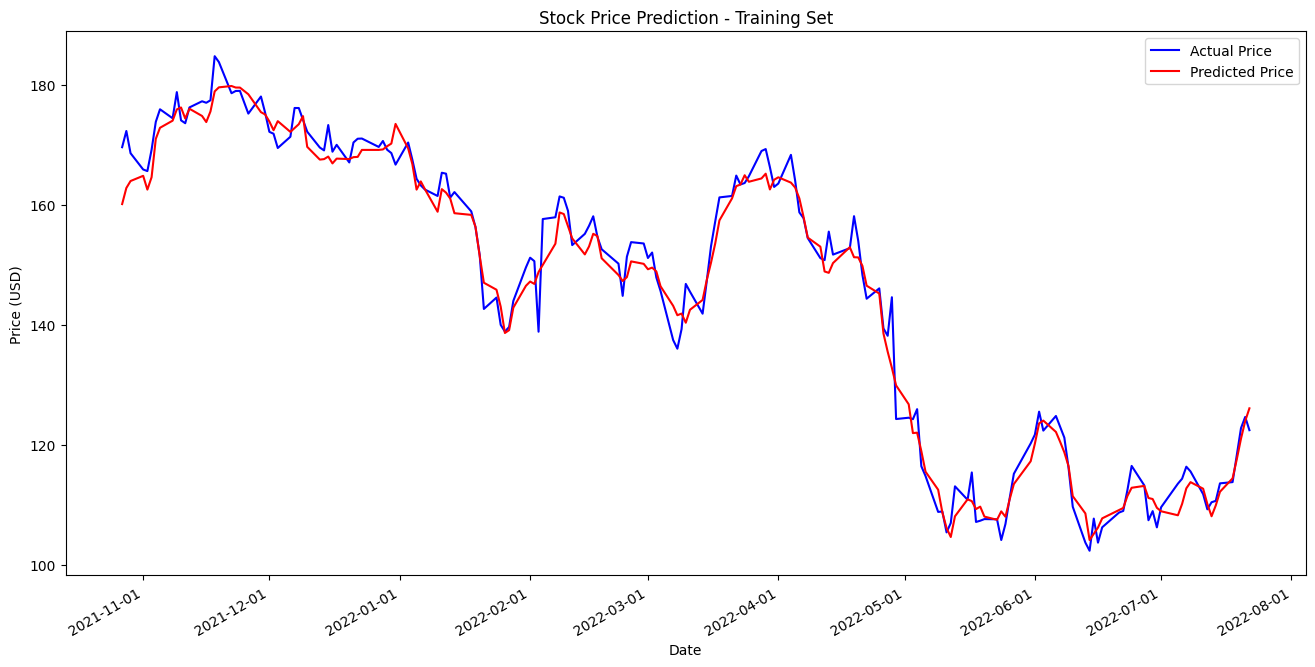

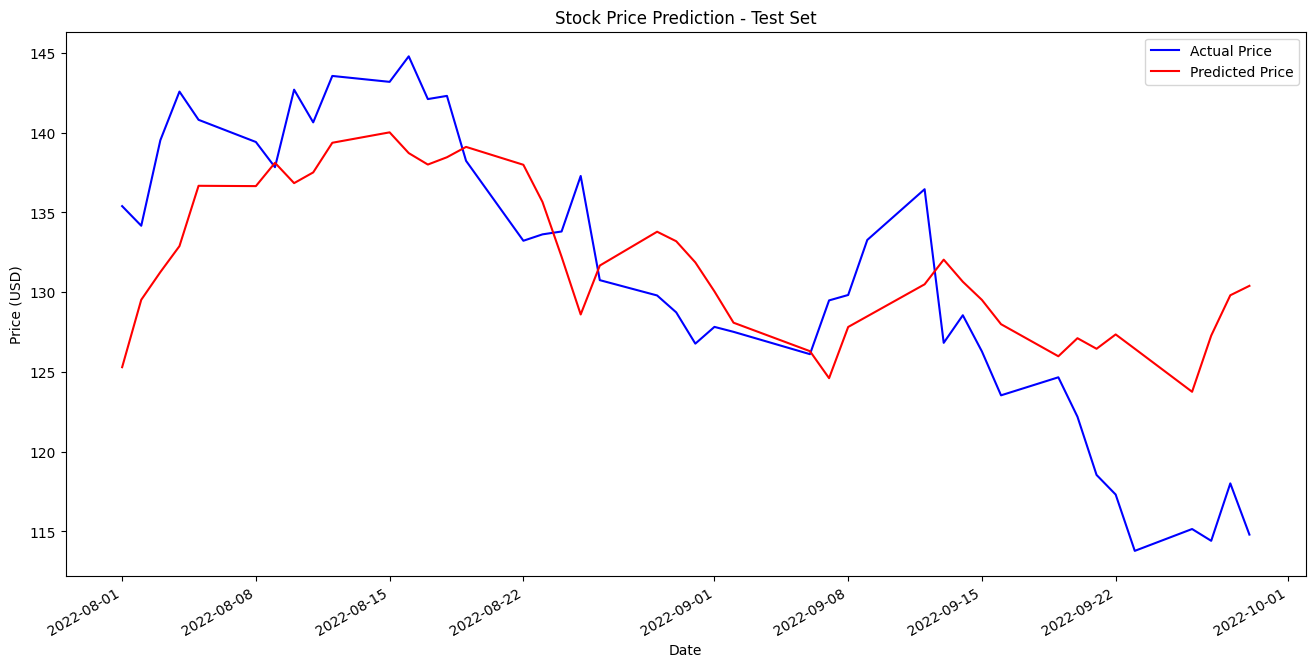

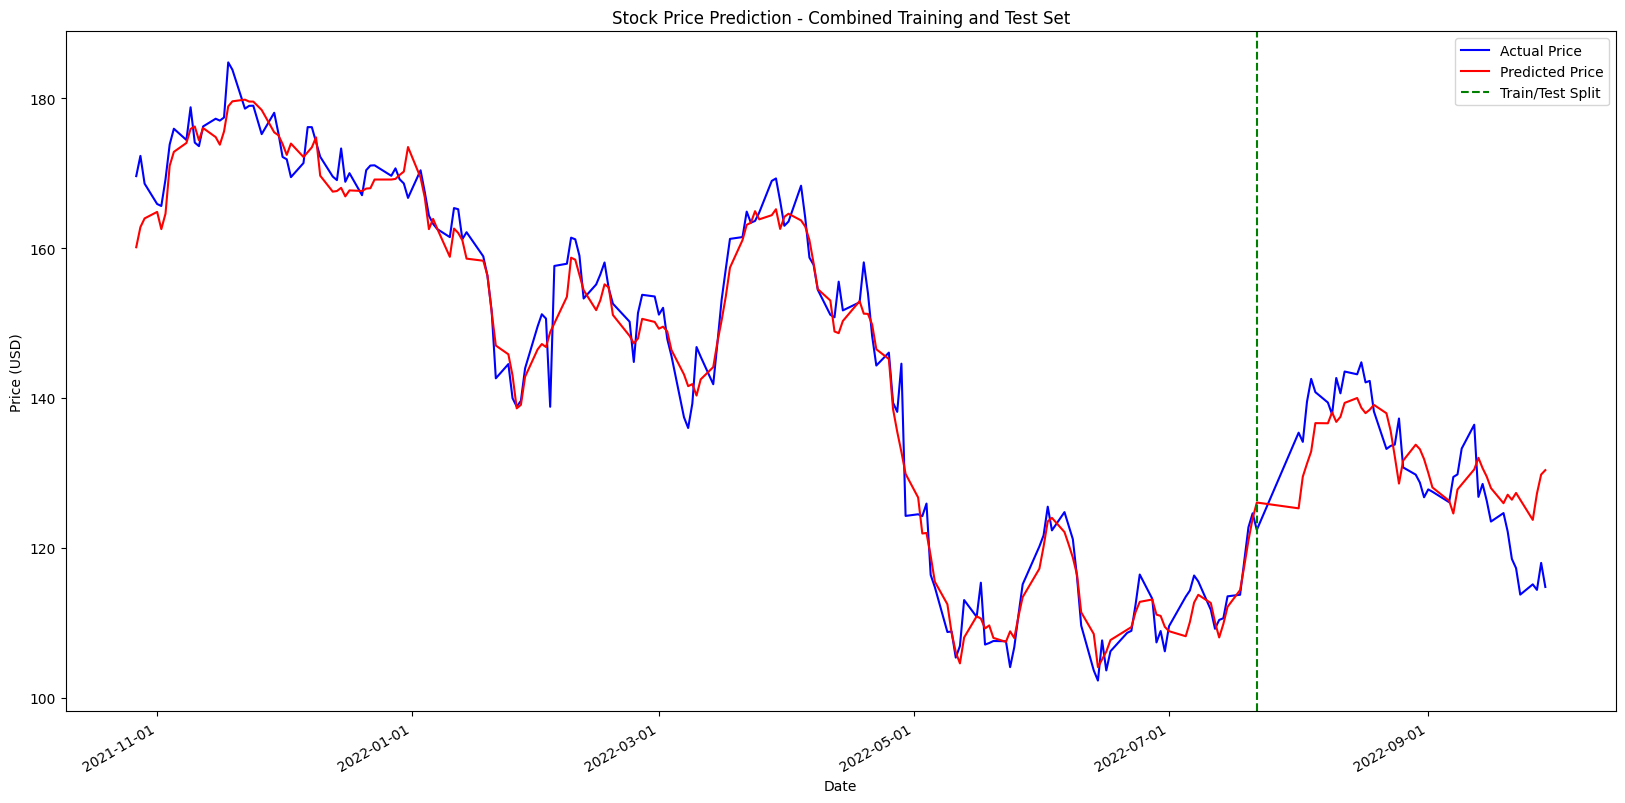

In [26]:
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_predictions(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}%')
    print(f'R-squared Score: {r2:.4f}')

# Make predictions
gru_model.eval()
with torch.no_grad():
    train_pred = gru_model(torch.from_numpy(train_sequences).float().to(device))
    test_pred = gru_model(torch.from_numpy(test_sequences).float().to(device))

# Inverse transform the predictions
train_pred = target_scaler.inverse_transform(train_pred.cpu().numpy())
test_pred = target_scaler.inverse_transform(test_pred.cpu().numpy())

# Evaluate train set predictions
print("Train Set Evaluation:")
evaluate_predictions(target_scaler.inverse_transform(train_targets), train_pred)

# Evaluate test set predictions
print("\nTest Set Evaluation:")
evaluate_predictions(target_scaler.inverse_transform(test_targets), test_pred)

# Get the dates for plotting
all_dates = pd.to_datetime(stock_data.index)
train_dates = all_dates[:train_split][sequence_length:]
test_dates = all_dates[train_split:][sequence_length:]

# Plot training set predictions
plt.figure(figsize=(16, 8))
plt.plot(train_dates, target_scaler.inverse_transform(train_targets), label='Actual Price', color='blue')
plt.plot(train_dates, train_pred, label='Predicted Price', color='red')
plt.title('Stock Price Prediction - Training Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.show()

# Plot test set predictions
plt.figure(figsize=(16, 8))
plt.plot(test_dates, target_scaler.inverse_transform(test_targets), label='Actual Price', color='blue')
plt.plot(test_dates, test_pred, label='Predicted Price', color='red')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.show()

# Combine train and test predictions
all_dates = np.concatenate([train_dates, test_dates])
all_actual = np.concatenate([target_scaler.inverse_transform(train_targets), target_scaler.inverse_transform(test_targets)])
all_pred = np.concatenate([train_pred, test_pred])

# Plot combined training and test set predictions
plt.figure(figsize=(20, 10))
plt.plot(all_dates, all_actual, label='Actual Price', color='blue')
plt.plot(all_dates, all_pred, label='Predicted Price', color='red')
plt.title('Stock Price Prediction - Combined Training and Test Set')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add a vertical line to separate training and test sets
plt.axvline(x=train_dates[-1], color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

In [27]:
print(gru_model)

GRUPredictor(
  (gru_1): GRU(36, 1024, batch_first=True)
  (gru_2): GRU(1024, 512, batch_first=True)
  (gru_3): GRU(512, 256, batch_first=True)
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
